## Импорт необходимых библиотек

In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import SegformerForSemanticSegmentation

## Конфигурация PyTorch

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


## Конфигурация модели

In [29]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 10
LR = 0.001
IMG_SIZE = 64

## Класс, описывающий датасет

In [30]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


## Аугментация данных

In [31]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

## Загрузка датасета

In [32]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [33]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)


## Разделение на обучающую и тестовую выборку, загрузка данных

In [34]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]


train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Функция по расчету необходимых метрик

In [35]:
# Метрики
def calculate_metrics(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()
    masks = (masks > 0.5).float()
    batch_ious, batch_dices = [], []

    for i in range(outputs.shape[0]):
        output = outputs[i]
        mask = masks[i]
        intersection = (output * mask).sum()
        union = (output + mask).sum() - intersection
        total = output.sum() + mask.sum()
        iou = (intersection / union).item() if union != 0 else float(output.sum() == 0 and mask.sum() == 0)
        dice = (2. * intersection / total).item() if total != 0 else 1.0
        batch_ious.append(iou)
        batch_dices.append(dice)

    return np.mean(batch_ious), np.mean(batch_dices)

## Обучение SegFormer

In [36]:
# Обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Использование предобученной модели SegFormer
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", num_labels=1)

# Перенос модели на устройство
print(device)
modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images).logits
        
        # Увеличиваем размер выходных данных до размера масок
        outputs = torch.nn.functional.interpolate(
            outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
        )
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images).logits
            
            # Увеличиваем размер выходных данных до размера масок
            outputs = torch.nn.functional.interpolate(
                outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
            )
            
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "segformer.pth")
        print(f"Best model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")



Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Epoch 1/10
Train Loss: 0.4913 | Test Loss: 0.6373
IoU: 0.7799 | Dice: 0.7799
------------------------
Best model saved at epoch 1 with IoU: 0.7799
Epoch 2/10
Train Loss: 0.4550 | Test Loss: 0.4416
IoU: 0.7595 | Dice: 0.7683
------------------------
Epoch 3/10
Train Loss: 0.4499 | Test Loss: 0.4377
IoU: 0.7660 | Dice: 0.7704
------------------------
Epoch 4/10
Train Loss: 0.4456 | Test Loss: 0.4355
IoU: 0.7504 | Dice: 0.7620
------------------------
Epoch 5/10
Train Loss: 0.4452 | Test Loss: 0.4533
IoU: 0.7618 | Dice: 0.7694
------------------------
Epoch 6/10
Train Loss: 0.4399 | Test Loss: 0.4225
IoU: 0.7699 | Dice: 0.7712
------------------------
Epoch 7/10
Train Loss: 0.4386 | Test Loss: 0.4288
IoU: 0.7557 | Dice: 0.7666
------------------------
Epoch 8/10
Train Loss: 0.4431 | Test Loss: 0.4199
IoU: 0.7746 | Dice: 0.7767
------------------------
Epoch 9/10
Train Loss: 0.4362 | Test Loss: 0.4653
IoU: 0.7525 | Dice: 0.7644
------------------------
Epoch 10/10
Train Loss: 0.4345 |

## Графики

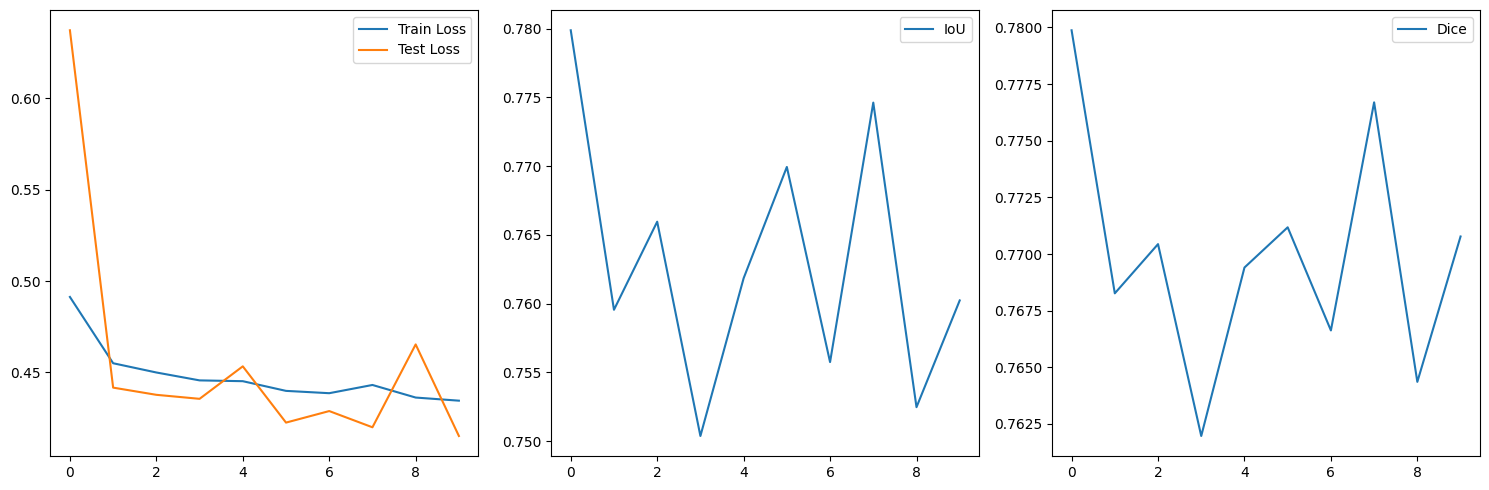

In [37]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()